# ODE Explorer Demo 1: Exponential decay models

A small appetizer example to find your way around this library. Introduces the most central components. Let's get to it!

In [1]:
import ode_explorer
from ode_explorer.models.model import ODEModel
from ode_explorer.integrators.integrator import Integrator
from ode_explorer.stepfunctions.stepfunctions import RungeKutta4, EulerMethod, DOPRI45
from ode_explorer.stepsize_control.stepsizecontroller import DOPRI45Controller
from ode_explorer.metrics.metric import DistanceToSolution

import numpy as np

from typing import Union

## Model definition

We start with the simplest of models - exponential decay. But do not assume that just because it is simple, it is just a toy example! In fact, the exponential decay model plays an important role in stability analysis of numerical integration methods, where it is also known as the *Dahlquist test equation*.

The differential equation for exponential decay with a rate $\lambda$ reads:
\begin{align}
y' &= - \lambda \cdot y, \\
y(0) &= y_0.
\end{align}

This we can easily cast into a model:

In [2]:
def exp_decay(t: float, y: Union[float, np.ndarray], lamb: float):
    return - lamb * y

Small side note: Due to clever operator overloading by NumPy, you can use the above model both for a scalar ODE, i.e. $y\in\mathbb{R}$, as well as for any higher dimension $y\in\mathbb{R}^n$. In fact, you can do the same with the decay parameter $\lambda$ - you can initialize it as a NumPy array $\lambda\in\mathbb{R}^n$ to simulate exponential decay with many different growth rates at the same time!

## Initial state

For any initial value problem (IVP), you need to provide a starting value of the process - that's why it is named that way! Try out different values by editing the cells below.

In [3]:
t_0 = 0.0
y_0 = 1.0  # np.ones(100)
lamb = 0.5 # decay rate of 0.5, so we expect half-life to be 2 * ln(2) ~ 1.38


initial_state = (t_0, y_0)

## Model construction

We wrap our exponential decay model into an ODEModel class.

In [4]:
model = ODEModel(ode_fn=exp_decay, fn_args={"lamb": lamb})

## Integrator construction

To solve our exponential decay differential equation, we instantiate an *Integrator* object, which keeps some useful state around for us.

In [5]:
integrator = Integrator()

I1222 21:04:17.087344 4650442240 integrator.py:81] Creating an Integrator instance.
I1222 21:04:17.089719 4650442240 integrator.py:59] Created an Integrator instance.


## Integration

That's how easy it is. Now let's solve our equation!

In [6]:
integrator.integrate_const(model=model,
                           step_func=RungeKutta4(output_format="zipped"),
                           initial_state=initial_state,
                           h=0.001,
                           num_steps=10000,
                           verbosity=1)

I1121 20:39:30.828557 4524047872 integrator.py:196] Starting integration.
100%|██████████| 10000/10000 [00:00<00:00, 24151.97it/s]
I1121 20:39:31.249732 4524047872 integrator.py:215] Finished integration.


As we can see from the progress bar, in the scalar case we managed about 24,000 iterations per second with the classical fourth order Runge-Kutta method. A successful numerical integration is called a *run* - let's find our experiment first by listing all runs.

In [7]:
integrator.list_runs()

| timestamp                  | run_id                               |
|----------------------------|--------------------------------------|
| 2020-12-22 21:04:19.936539 | 41bb2aa5-6698-4aeb-8376-e742b4ab4bea |


And there we have our runs, neatly tabulated. The more experiments you do, the more runs will show up in this table. Each run has its own identifier called *run_id*, which is a UUID generated during the run. 

We also see that the output format of our step function is "zipped" - that means that internally, the step function returns a dictionary of floats instead of a dictionary of state vectors. This is beneficial for later analysis with pandas, but creates a performance hit. Try out the other option if you want - just supply output_format="variables" to the RungeKutta4 constructor.

Let us look at the result of our first run - instead of selecting it by the run's ID as you normally would, we can also type "latest" to indicate that we want the newest result.

In [8]:
result = integrator.return_result_data(run_id="latest")

result

,t,y
0,0.000000,1.000000
1,0.001000,0.999501
2,0.002996,0.998507
3,0.006471,0.996782
4,0.011897,0.994102
...,...,...
76,8.909652,0.045433
77,9.233092,0.041889
78,9.565099,0.038626
79,9.906091,0.035627


That looks ok - although staring at the numbers is not really the best option here for assessing whether our solution actually makes sense. If you have worked with pandas before, you may have noticed by the print output that the returned "result" object is in fact a pandas DataFrame - which can be plotted immediately. Let's do it!

<AxesSubplot:xlabel='t'>

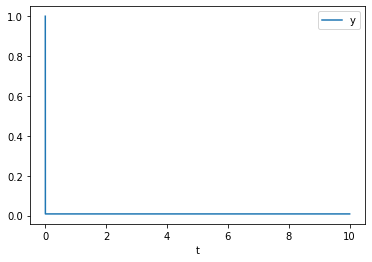

In [9]:
result.plot(x="t", y="y")

That looks much more familiar! Great job, the general shape of the curve looks correct for our example. But how accurate is the solution really? That is something we cannot directly infer from this graph. And if you had to assert numbers like these for a Mars mission launch, you would surely want a way to validate that your algorithm does not go crazy - a lot could be at stake!

Luckily, for an exponential decay model like this, we have a closed form solution available - literally the exponential function. So how about we check our calculations against the real solution?

## Solution distance experiment

We define our solution, which mathematically is a function $y: \mathbb{R}\rightarrow\mathbb{R}^n$. For the exponential decay model with decay rate $\lambda$ and initial state $y_0\in\mathbb{R}^n$, the exact solution is given for every $t \geq 0$ as
\begin{equation}
\hat{y}(t) = y_0 \exp(-\lambda t).
\end{equation}

In [10]:
def sol(t):
    return y_0 * np.exp(-lamb * t)

Nice! Notice we reused the $y_0$ object from earlier in the notebook. Now we start another integrator run with the same parameters, but this time we add a *Metric*, the *Euclidean distance from the exact solution* $\hat{y}$
\begin{equation}
d(y, \hat{y}, t) = \left\lVert y(t) - \hat{y}(t) \right\rVert_2 = \sqrt{\sum_i (y_i - \hat{y}_i)^2}.
\end{equation}

If our algorithm is correct, which it should be (it is a built-in!), the distance should be small throughout the run, indicating an accurate numerical approximation. Fingers crossed!

*Tip: You can also calculate other norms, like the maximum norm or the $L_1$ distance between solution and approximation. To try out other norms, pass the **norm** argument in the DistanceToSolution constructor (norm=1 is $L_1$ distance, norm="inf" is maximum norm distance)*

In [11]:
integrator.integrate_const(model=model,
                           step_func=RungeKutta4(output_format="zipped"),
                           initial_state=initial_state,
                           h=0.001,
                           num_steps=10000,
                           verbosity=1,
                           metrics=[DistanceToSolution(solution=sol, name="l2_distance")])

I1121 20:39:31.957906 4524047872 integrator.py:196] Starting integration.
100%|██████████| 10000/10000 [00:00<00:00, 15507.99it/s]
I1121 20:39:32.605935 4524047872 integrator.py:215] Finished integration.


Looks like that worked! Let us quickly confirm.

In [12]:
integrator.list_runs()

| timestamp                  | run_id                               | stepfunc_output_format   |
|----------------------------|--------------------------------------|--------------------------|
| 2020-11-21 20:39:30.828394 | 79006e38-aa9e-4a83-951f-04a4498e9dbc | zipped                   |
| 2020-11-21 20:39:31.957501 | 92757afd-42d9-40aa-87f2-cdfc56fb9ccd | zipped                   |


Perfect! There is a new run listed in the table. It should be holding the distance to the solution as metric values. To request the metric data, we can use the *return_metrics* interface exposed by the integrator.

In [9]:
metrics = integrator.return_metrics(run_id="latest")

metrics

,step_size,n_accept,n_reject,iteration
0,0.001000,0,0,NaN
1,0.001996,1,0,1.0
2,0.002098,2,0,2.0
3,0.002183,3,0,3.0
4,0.002254,4,0,4.0
...,...,...,...,...
1094,0.116093,1094,0,1094.0
1095,0.121607,1095,0,1095.0
1096,0.127620,1096,0,1096.0
1097,0.103202,1097,0,1097.0


Lots of zeros and numbers around machine precision there - that looks promising! The metrics object above is also a pandas DataFrame, so let us plot the solution distance over time:

<AxesSubplot:>

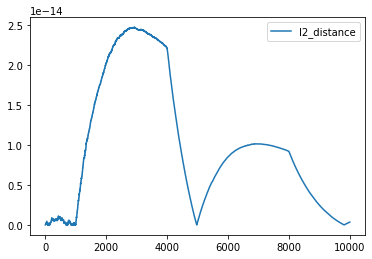

In [14]:
metrics.plot()

From this plot, it appears that the Euclidean distance of our numerical solution to the exact solution never exceeds $3\cdot 10^{-14}$ across all 10,000 iterations. Though the distance does not appear to be uniformly at around machine precision ($\approx 10^{-16}$), but rather periodically increasing and decreasing - an interesting artifact. We can quickly print some statistics, too:

In [15]:
metrics.describe()

,l2_distance
count,1.000100e+04
mean,9.958515e-15
std,8.205534e-15
min,0.000000e+00
25%,2.655862e-15
50%,9.103829e-15
75%,1.618150e-14
max,2.473022e-14


That confirms what we were seeing. In theory, the classical Runge-Kutta method has order of consistency 4, meaning that the discretization error is globally of $\mathcal{O}(h^4)$. For a step size of $h = 0.001$ that we chose, this would place us in the range of $10^{-12}$ relative to $h = 1$ (ignoring constants) - which seems all right given our results, and considering that the condition number of the exponential decay equation is not large for $\lambda = 0.5$, no stiffness effects are coming to haunt us here, either. 

This concludes the first small demo of the ode-explorer library - if you made it this far, thanks for trying it out, and see you in the next one!